In [90]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
   sys.path.append(project_root)

from source.utils.minio_helper import read_df_from_minio

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # Agar list panjang tidak terpotong

BUCKET_NAME = "mlbb-lakehouse"

In [93]:
df_enriched = read_df_from_minio(BUCKET_NAME, "silver/silver_draft_enriched.parquet", file_format='parquet')
df_pick = read_df_from_minio(BUCKET_NAME, "gold/gold_draft_pick_features.parquet", file_format='parquet')
df_match = read_df_from_minio(BUCKET_NAME, "gold/gold_match_features.parquet", file_format='parquet')

print("silver enriched shape:", df_enriched.shape)
print("gold_draft_pick_features shape:", df_pick.shape)
print("gold_match_features shape:", df_match.shape)

silver enriched shape: (8276, 21)
gold_draft_pick_features shape: (4139, 15)
gold_match_features shape: (827, 10)


In [94]:
def create_gold_layer(df_silver):
    # A. Gold Pick Features
    df_picks = df_silver[df_silver['phase'] == 'pick'].copy()
    
    # Normalisasi Score
    max_score = df_picks['counter_score'].abs().max()
    if max_score == 0: max_score = 1
    df_picks['counter_score_norm'] = df_picks['counter_score'] / max_score
    
    # B. Gold Match Features (Aggregasi)
    agg_rules = {
        'is_winner_team': 'first',
        'team_name': 'first',
        'win_rate': 'mean',
        'tier_score': 'mean',
        'counter_score': 'mean',
        'counter_score_norm': 'mean',
        'hero_name_normalized': 'count'
    }
    
    df_matches = df_picks.groupby(['match_id', 'team_side']).agg(agg_rules).reset_index()
    df_matches = df_matches.rename(columns={
        'win_rate': 'avg_win_rate',
        'tier_score': 'avg_meta_score',
        'counter_score': 'avg_counter_score',
        'counter_score_norm': 'avg_counter_score_norm',
        'hero_name_normalized': 'total_hero'
    })
    
    return df_picks, df_matches

df_gold_picks, df_gold_matches = create_gold_layer(df_enriched)
print('Di fungsi create_gold_layer')
print(f"Gold Picks Shape: {df_gold_picks.shape}")
print(f"Gold Matches Shape: {df_gold_matches.shape}")

Di fungsi create_gold_layer
Gold Picks Shape: (4139, 22)
Gold Matches Shape: (828, 9)


In [95]:
# 1. Cek Missing Values (PENTING: Pastikan tidak ada NaN di fitur utama)
print("\n--- MISSING VALUES CHECK ---")
missing = df_gold_matches.isnull().sum()
print(missing[missing > 0])

# 2. Cek Statistik Deskriptif
# Perhatikan min/max pada avg_counter_score. Apakah range-nya masuk akal?
print("\n--- DESCRIPTIVE STATS ---")
display(df_gold_matches[['avg_win_rate', 'avg_meta_score', 'avg_counter_score', 'avg_counter_score_norm']].describe())
print(df_gold_matches[['avg_win_rate', 'avg_meta_score', 'avg_counter_score', 'avg_counter_score_norm']].describe())

# 3. Validasi Jumlah Hero
# Jika ada match yang heronya < 5, data itu sampah untuk ML.
invalid_drafts = df_gold_matches[df_gold_matches['total_hero'] != 5]
print(f"\n--- DATA INTEGRITY: INVALID DRAFTS ---")
print(f"Jumlah tim dengan hero != 5: {len(invalid_drafts)}")
if len(invalid_drafts) > 0:
   print(invalid_drafts.head())
   display(invalid_drafts.head())


--- MISSING VALUES CHECK ---
Series([], dtype: int64)

--- DESCRIPTIVE STATS ---


,avg_win_rate,avg_meta_score,avg_counter_score,avg_counter_score_norm
count,828.000000,828.000000,828.000000,828.000000
mean,49.849319,2.163285,-0.000013,-0.000003
std,1.151807,0.635130,0.249444,0.053992
min,46.358000,0.600000,-0.946000,-0.204762
25%,49.082000,1.800000,-0.140000,-0.030303
50%,49.872000,2.200000,0.000000,0.000000
75%,50.598500,2.600000,0.140000,0.030303
max,53.342000,4.400000,0.944000,0.204329


       avg_win_rate  avg_meta_score  avg_counter_score  avg_counter_score_norm
count    828.000000      828.000000         828.000000              828.000000
mean      49.849319        2.163285          -0.000013               -0.000003
std        1.151807        0.635130           0.249444                0.053992
min       46.358000        0.600000          -0.946000               -0.204762
25%       49.082000        1.800000          -0.140000               -0.030303
50%       49.872000        2.200000           0.000000                0.000000
75%       50.598500        2.600000           0.140000                0.030303
max       53.342000        4.400000           0.944000                0.204329

--- DATA INTEGRITY: INVALID DRAFTS ---
Jumlah tim dengan hero != 5: 1
     match_id team_side  is_winner_team   team_name  avg_win_rate  \
588       295      left            True  AuroraRORA       49.1925   

     avg_meta_score  avg_counter_score  avg_counter_score_norm  total_hero  
58

,match_id,team_side,is_winner_team,team_name,avg_win_rate,avg_meta_score,avg_counter_score,avg_counter_score_norm,total_hero
588,295,left,True,AuroraRORA,49.1925,4.0,0.1575,0.034091,4


📊 ZERO SCORE DIAGNOSTIC
Total Pick Rows: 4139
Rows with Score 0: 2026
Percentage Zero: 48.95%
⚠️ CAUTION: Cukup banyak score 0. Apakah data counter kurang lengkap?


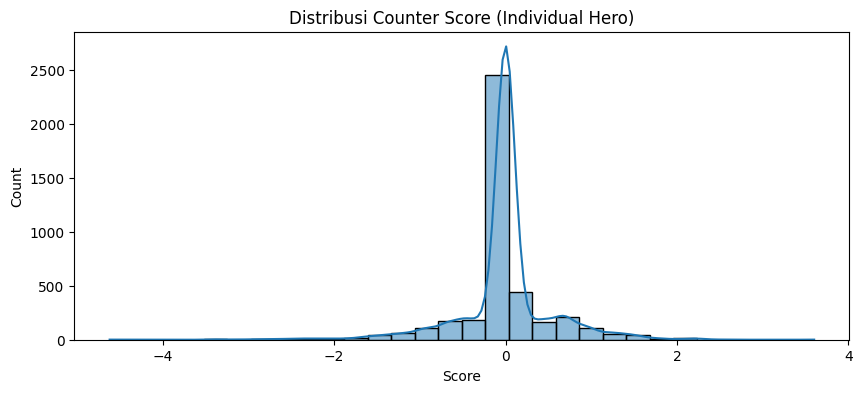

In [96]:
# Hitung persentase hero yang Counter Score-nya 0
zero_score_count = (df_gold_picks['counter_score'] == 0).sum()
total_picks = len(df_gold_picks)
pct_zero = (zero_score_count / total_picks) * 100

print(f"📊 ZERO SCORE DIAGNOSTIC")
print(f"Total Pick Rows: {total_picks}")
print(f"Rows with Score 0: {zero_score_count}")
print(f"Percentage Zero: {pct_zero:.2f}%")

# Interpretasi
if pct_zero > 50:
    print("⚠️ WARNING: Lebih dari 50% data counter score bernilai 0. Cek kembali dictionary counter di Silver!")
elif pct_zero > 20:
    print("⚠️ CAUTION: Cukup banyak score 0. Apakah data counter kurang lengkap?")
else:
    print("✅ PASS: Distribusi score terlihat normal (sedikit yang 0).")

# Visualisasi Histogram Score
plt.figure(figsize=(10, 4))
sns.histplot(df_gold_picks['counter_score'], bins=30, kde=True)
plt.title("Distribusi Counter Score (Individual Hero)")
plt.xlabel("Score")
plt.show()


--- FEATURE CORRELATION WITH WINNER ---
is_winner_team            1.000000
avg_meta_score            0.044904
avg_counter_score_norm   -0.023964
avg_win_rate             -0.078336
Name: is_winner_team, dtype: float64


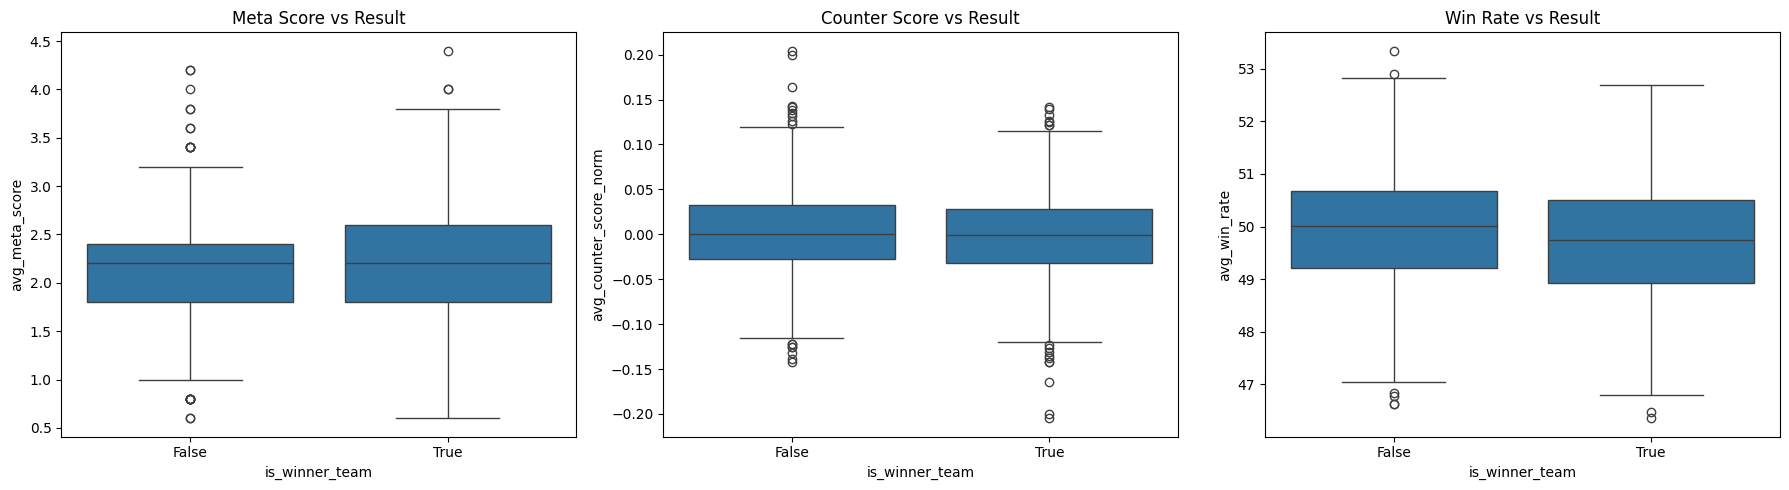

In [97]:
# Hitung Korelasi
features = ['is_winner_team', 'avg_win_rate', 'avg_meta_score', 'avg_counter_score_norm']
corr_matrix = df_gold_matches[features].corr()

print("\n--- FEATURE CORRELATION WITH WINNER ---")
print(corr_matrix['is_winner_team'].sort_values(ascending=False))

# Visualisasi Boxplot
# Kita ingin melihat apakah tim yang MENANG (1) cenderung punya score lebih tinggi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='is_winner_team', y='avg_meta_score', data=df_gold_matches, ax=axes[0])
axes[0].set_title('Meta Score vs Result')

sns.boxplot(x='is_winner_team', y='avg_counter_score_norm', data=df_gold_matches, ax=axes[1])
axes[1].set_title('Counter Score vs Result')

sns.boxplot(x='is_winner_team', y='avg_win_rate', data=df_gold_matches, ax=axes[2])
axes[2].set_title('Win Rate vs Result')

plt.tight_layout()
plt.show()

In [98]:
print(df_pick.isnull().mean().sort_values(ascending=False).head(20))

match_id                0.0
team_side               0.0
team_name               0.0
hero_name_normalized    0.0
is_winner_team          0.0
win_rate                0.0
pick_rate               0.0
tier_score              0.0
counter_score           0.0
counter_score_norm      0.0
role                    0.0
lane                    0.0
speciality              0.0
source_file             0.0
processed_at            0.0
dtype: float64


In [99]:
print(df_match.isnull().mean().sort_values(ascending=False).head(20))

match_id                       0.0
team_side                      0.0
is_winner_team                 0.0
team_name                      0.0
avg_win_rate_team              0.0
avg_meta_score_team            0.0
avg_counter_score_team         0.0
avg_counter_score_norm_team    0.0
total_heroes_count             0.0
processed_at                   0.0
dtype: float64


In [100]:
df_pick['hero_name_normalized'].value_counts().head(20)

hero_name_normalized
yisunshin    220
lancelot     188
granger      178
gatotkaca    178
zhuxin       172
kimmy        165
harith       164
lapulapu     153
cici         145
kalea        136
arlott       129
pharsa       124
uranus       105
grock        105
hayabusa      97
esmeralda     97
baxia         96
hylos         85
phoveus       85
moskov        80
Name: count, dtype: int64

In [101]:
df_pick[df_pick['hero_name_normalized'].str.contains('wu|zhe', na=False)]


,match_id,team_side,team_name,hero_name_normalized,is_winner_team,win_rate,pick_rate,tier_score,counter_score,counter_score_norm,role,lane,speciality,source_file,processed_at


In [102]:
df_gold_picks[
    (df_gold_picks['win_rate'] == 0) &
    (df_gold_picks['pick_rate'] == 0) &
    (df_gold_picks['ban_rate'] == 0)
]['hero_name_normalized'].value_counts().head(10)


Series([], Name: count, dtype: int64)

In [103]:
numeric_cols = [
    'win_rate', 'pick_rate', 'ban_rate',
    'tier_score', 'counter_score'
]

print(df_gold_picks[numeric_cols].describe())


          win_rate    pick_rate     ban_rate   tier_score  counter_score
count  4139.000000  4139.000000  4139.000000  4139.000000    4139.000000
mean     49.849478     0.881493     8.743941     2.162841      -0.000051
std       2.742771     0.622646    12.477346     1.731231       0.553104
min      43.850000     0.050000     0.070000     0.000000      -4.620000
25%      47.430000     0.380000     0.820000     1.000000       0.000000
50%      50.020000     0.760000     1.870000     1.000000       0.000000
75%      51.660000     1.210000    13.910000     4.000000       0.040000
max      56.830000     2.870000    44.220000     5.000000       3.600000


In [104]:
# 1. Ambil sampel hero unik dari Draft
draft_heroes = sorted(df_enriched['hero_name_normalized'].unique())
print(f"Jumlah Hero Unik di Draft: {len(draft_heroes)}")
print("Sampel Hero Draft:", draft_heroes[:10])

# 2. Load data Dictionary Counter (dari Bronze/Silver source kamu)
# (Ganti path sesuai lokasi file kamu)
# df_counter = pd.read_parquet('bronze/counter_hero/bronze_hero_counter.parquet') 
# counter_keys = set(df_counter['hero_name_normalized'].unique())

# --- SIMULASI MANUAL ---
# Karena saya tidak punya file counter kamu, coba cek manual string ini:
test_hero = 'cici' # Ganti dengan hero yang kamu tahu ada
print(f"\nApakah '{test_hero}' ada di draft?")
# Cek persis
print(f"Exact match: {test_hero in draft_heroes}")

# Cek apakah ada masalah spasi?
spasi_check = [h for h in draft_heroes if ' ' in h]
if spasi_check:
    print(f"\n⚠️ WARNING: Ada hero dengan spasi: {spasi_check[:5]}")
else:
    print("\n✅ Tidak ada spasi di nama hero draft.")

# Cek Case Sensitivity
upper_check = [h for h in draft_heroes if any(c.isupper() for c in h)]
if upper_check:
    print(f"\n⚠️ WARNING: Ada huruf besar di draft: {upper_check[:5]}. Dictionary biasanya lowercase.")

Jumlah Hero Unik di Draft: 96
Sampel Hero Draft: ['akai', 'alice', 'alpha', 'angela', 'arlott', 'aurora', 'badang', 'bane', 'baxia', 'beatrix']

Apakah 'cici' ada di draft?
Exact match: True

✅ Tidak ada spasi di nama hero draft.


In [105]:
print(df_match.corr(numeric_only=True)['is_winner_team'].sort_values(ascending=False))


is_winner_team                 1.000000
avg_meta_score_team            0.041641
match_id                      -0.000886
avg_counter_score_norm_team   -0.024749
avg_counter_score_team        -0.024749
avg_win_rate_team             -0.077708
total_heroes_count                  NaN
Name: is_winner_team, dtype: float64


In [106]:
assert df_pick['hero_name_normalized'].isnull().sum() == 0
assert (df_pick['win_rate'] < 0).sum() == 0
assert (df_pick['win_rate'] > 100).sum() == 0
assert df_match['match_id'].duplicated().sum() == 0


AssertionError: 

In [ ]:
def create_match_level_data(df):
    # Pisahkan tim kiri dan kanan
    left = df[df['team_side'] == 'left'].copy()
    right = df[df['team_side'] == 'right'].copy()
    
    # Gabungkan kembali berdasarkan match_id
    df_match = pd.merge(
        left, 
        right, 
        on='match_id', 
        suffixes=('_T1', '_T2') # T1 = Left, T2 = Right
    )
    
    return df_match

df_validation = create_match_level_data(df_match)
print(f"Data Siap Validasi: {df_validation.shape[0]} Matches")

Data Siap Validasi: 413 Matches


In [ ]:
df_validation['Diff_Counter'] = df_validation['avg_counter_score_team_T1'] - df_validation['avg_counter_score_team_T2']
df_validation['Diff_Meta']    = df_validation['avg_meta_score_team_T1'] - df_validation['avg_meta_score_team_T2']
df_validation['Diff_WR']      = df_validation['avg_win_rate_team_T1'] - df_validation['avg_win_rate_team_T2']

In [ ]:
df_validation['Target_Winner'] = df_validation['is_winner_team_T1'].astype(int)

# 4. Cek Korelasi (The Moment of Truth)
cols_to_check = ['Target_Winner', 'Diff_Counter', 'Diff_Meta', 'Diff_WR']
correlation = df_validation[cols_to_check].corr()['Target_Winner'].sort_values(ascending=False)

print("\n📊 KORELASI FITUR DENGAN KEMENANGAN:")
print(correlation)


📊 KORELASI FITUR DENGAN KEMENANGAN:
Target_Winner    1.000000
Diff_Meta        0.059385
Diff_Counter    -0.042167
Diff_WR         -0.097032
Name: Target_Winner, dtype: float64


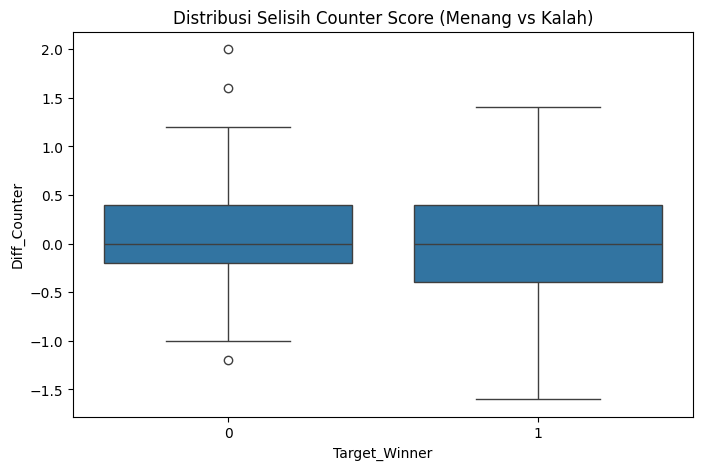

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Target_Winner', y='Diff_Counter', data=df_validation)
plt.title("Distribusi Selisih Counter Score (Menang vs Kalah)")
plt.show()